# Notebook for calculating Bispectrum
This notebook illustrates how to calculate the vanilla halo model bispectrum with this code

## Preparations

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
import camb

# Project imports
import pyhalomodel as halo

In [2]:
# Set cosmological parameters
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
As = 2e-9
ns = 0.96
w = -1.0
wa = 0.0
m_nu = 0.0 # [eV]
sigma_8_set = True # If True uses the following value
sigma_8  = 0.8

# Wavenumber range [h/Mpc]
kmin, kmax = 1e-3, 100.
nk = 101
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshift
z = 0.

# Halo mass range [Msun/h] over which to integrate
Mmin, Mmax = 1e9, 1e17
nM = 256
Ms = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)

# CAMB
zmax_CAMB = 2.
kmax_CAMB = 200.

# Plot colours
col_lin = 'grey'
col_mat = 'C0'
col_gal = 'C1'
col_mg  = 'C4'

# Plot line styles
ls_li = '-'
ls_hm = '-'
ls_2h = '--'
ls_1h = ':'

# Plot labels
klab = r'$k\,/\,h \mathrm{Mpc}^{-1}$'
Pklab = r'$P(k)/(h^{-1}\,\mathrm{Mpc})^3$'

## Calculate linear powerspectrum (with CAMB)

In [3]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()
wb = Omega_b*h**2
wc = Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=[z], kmax=kmax_CAMB) # Setup the linear matter power spectrum

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if sigma_8_set:
    camb_results = camb.get_results(pars)
    sigma_8_init = (camb_results.get_sigma8()[[z].index(0.)]).item()
    print('Initial sigma_8:', sigma_8_init)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Now get the linear power spectrum
Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear=False, 
                                            hubble_units=True, 
                                            k_hunit=True, 
                                            kmax=kmax_CAMB,
                                            var1=camb.model.Transfer_tot,
                                            var2=camb.model.Transfer_tot, 
                                            zmax=zmax_CAMB,
                                           )
Omega_m  = pars.omegam # Also extract the matter density
Pks_lin = Pk_lin.P(z, ks) # Single out the linear P(k) interpolator and evaluate linear power
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[[z].index(0.)]).item()
if sigma_8_set: print('Final sigma_8:', sigma_8)

Initial sigma_8: 0.8052480547740136
Final sigma_8: 0.7999999999999995


## Initialization of halo model and profile

In [4]:
# Initialise halo model
hmod = halo.model(z, Omega_m, name='Tinker et al. (2010)', Dv=330.)
print(hmod)

Halo model: Tinker et al. (2010)
Scale factor: 1.000
Redshift: 0.000
Omega_m(z=0): 0.300
delta_c: 1.6860
Delta_v: 330.0
Parameters:
alpha: 0.370; beta: 0.571; gamma: 0.944; phi: -0.829; eta: -0.261
A: 1.001; a: 0.228
B: 0.183; b: 1.500
C: 0.289; c: 2.400



In [5]:
# Get sigma(R) from CAMB
Rs = hmod.Lagrangian_radius(Ms)
sigmaRs = camb_results.get_sigmaR(Rs, hubble_units=True, return_R_z=False)[[z].index(z)]

In [6]:
# Halo window functions
rvs = hmod.virial_radius(Ms)
cs = halo.concentration(Ms, z, method='Duffy et al. (2008)', halo_definition='Mvir')
Uk = halo.window_function(ks, rvs, cs, profile='NFW')

# Create a profile, need mass_tracer=True here
matter_profile = halo.profile.Fourier(ks, Ms, Uk, amplitude=Ms, normalisation=hmod.rhom, mass_tracer=True) 
print(matter_profile)

Mass tracer: True
Discrete tracer: False
Field normalisation: 83262006415.74907
Number of wavenumber bins: 101
Number of mass bins: 256
Wavenumber range [log10(h/Mpc)]: -3.000 2.000
Halo mass range [log10(Msun/h)]: 9.000 17.000
The following are at the low and high halo mass ends
Profile amplitude mean [log10]: 9.0 17.0
Dimensionless profiles at low k (should be ~1): 0.99999999998453 0.9999950419099879
Dimensionful profiles at low k (should be amplitudes): 0.012010279874727825 1201022.0326864931



## Calculate power spectrum (optional)

In [7]:
# Calculate the halo-model power spectrum
Pk_2h, Pk_1h, Pk_hm = hmod.power_spectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True)

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.33872493733519926
Calculating power: m-m
Halomodel calculation time [s]: 0.018503904342651367 



## Calculate bispectrum

In [8]:
result=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, fastCalc=False)
result_fastCalc=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, fastCalc=True)



Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.33872493733519926
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 0.04773354530334473 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.33872493733519926
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 0.018133878707885742 



In [9]:
result_unequi=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, onlyEquilateral=False, fastCalc=False)
result_unequi_fastCalc=hmod.bispectrum(ks, Pks_lin, Ms, sigmaRs, {'m': matter_profile}, verbose=True, onlyEquilateral=False, fastCalc=True)



Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.33872493733519926
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 77.31545448303223 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.33872493733519926
Calculating bispectrum: m-m-m
Bispectrum calculation time [s]: 28.747405529022217 



## Plots

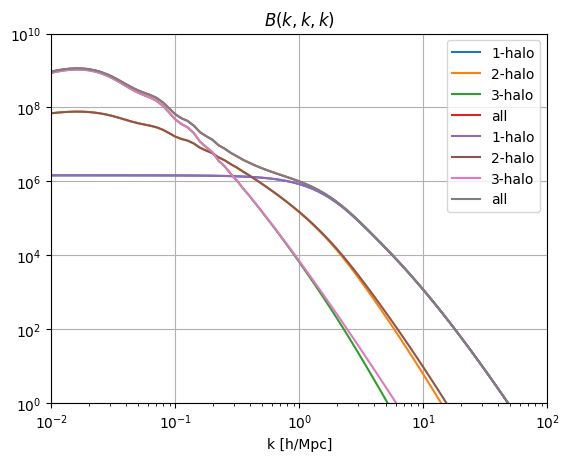

In [10]:
plt.title(r"$B(k,k,k)$")
plt.xlabel("k [h/Mpc]")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
plt.ylim(1, 1e10)
plt.plot(ks, result[2]['m-m-m'], label='1-halo')
plt.plot(ks, result[1]['m-m-m'], label='2-halo')
plt.plot(ks, result[0]['m-m-m'], label='3-halo')
plt.plot(ks, result[3]['m-m-m'], label='all')

plt.plot(ks, result_fastCalc[2]['m-m-m'], label='1-halo')
plt.plot(ks, result_fastCalc[1]['m-m-m'], label='2-halo')
plt.plot(ks, result_fastCalc[0]['m-m-m'], label='3-halo')
plt.plot(ks, result_fastCalc[3]['m-m-m'], label='all')

plt.legend()



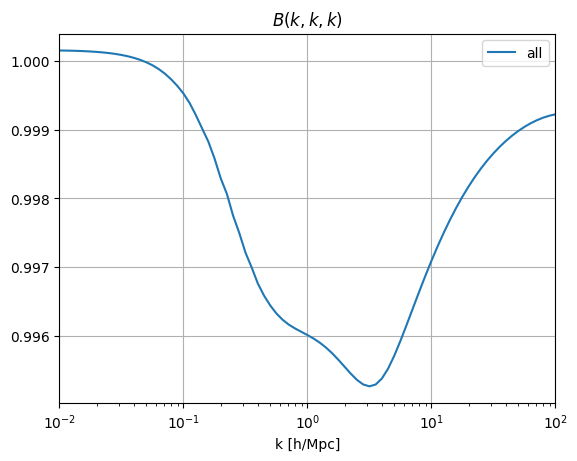

In [14]:
plt.title(r"$B(k,k,k)$")
plt.xlabel("k [h/Mpc]")
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
#plt.ylim(1, 1e10)
#plt.plot(ks, result[2]['m-m-m']/result_fastCalc[2]['m-m-m'], label='1-halo')
#plt.plot(ks, result[1]['m-m-m']/result_fastCalc[1]['m-m-m'], label='2-halo')
#plt.plot(ks, result[0]['m-m-m']/result_fastCalc[0]['m-m-m'], label='3-halo')
plt.plot(ks, result[3]['m-m-m']/result_fastCalc[3]['m-m-m'], label='all')


plt.legend()


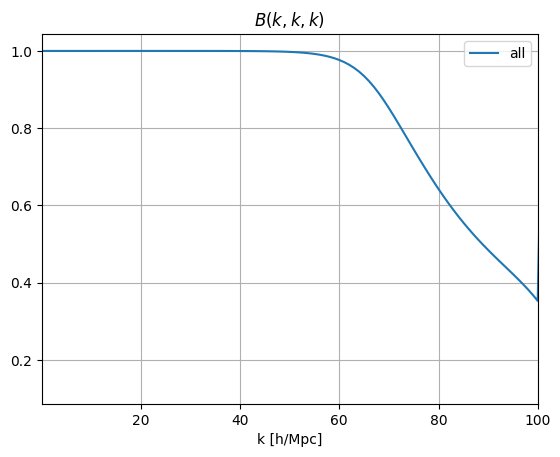

In [17]:
plt.title(r"$B(k,k,k)$")
plt.xlabel("k [h/Mpc]")
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
#plt.ylim(1, 1e10)
#plt.plot(ks, result[2]['m-m-m']/result_fastCalc[2]['m-m-m'], label='1-halo')
#plt.plot(ks, result[1]['m-m-m']/result_fastCalc[1]['m-m-m'], label='2-halo')
#plt.plot(ks, result[0]['m-m-m']/result_fastCalc[0]['m-m-m'], label='3-halo')
plt.plot(result_unequi[3]['m-m-m'].flatten()/result_unequi_fastCalc[3]['m-m-m'].flatten(), label='all')


plt.legend()


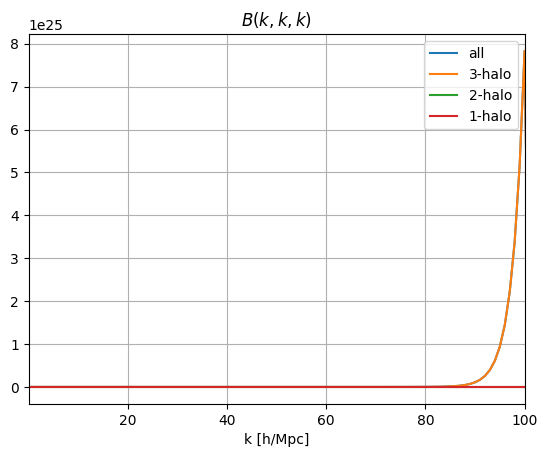

In [19]:
plt.title(r"$B(k,k,k)$")
plt.xlabel("k [h/Mpc]")
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
#plt.ylim(1, 1e10)

plt.plot(result_unequi[3]['m-m-m'].flatten(), label='all')
plt.plot(result_unequi[0]['m-m-m'].flatten(), label='3-halo')

plt.plot(result_unequi[1]['m-m-m'].flatten(), label='2-halo')
plt.plot(result_unequi[2]['m-m-m'].flatten(), label='1-halo')



plt.legend()


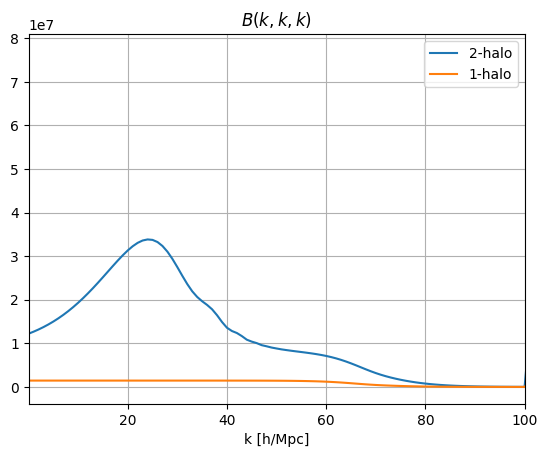

In [22]:
plt.title(r"$B(k,k,k)$")
plt.xlabel("k [h/Mpc]")
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
#plt.ylim(1, 1e10)

#plt.plot(result_unequi_fastCalc[3]['m-m-m'].flatten(), label='all')
#plt.plot(result_unequi_fastCalc[0]['m-m-m'].flatten(), label='3-halo')

plt.plot(result_unequi_fastCalc[1]['m-m-m'].flatten(), label='2-halo')
plt.plot(result_unequi_fastCalc[2]['m-m-m'].flatten(), label='1-halo')



plt.legend()


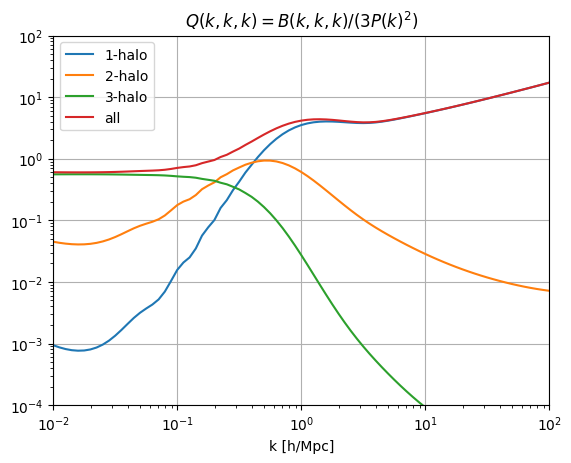

In [12]:
plt.title(r"$Q(k,k,k)=B(k,k,k)/(3 P(k)^2)$")
plt.xlabel("k [h/Mpc]")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
plt.ylim(1e-4, 100)
plt.plot(ks, np.array([result_unequi[2]['m-m-m'][i,i,i] for i in range(len(ks))])/3/Pk_hm['m-m']/Pk_hm['m-m'], label='1-halo')
plt.plot(ks, np.array([result_unequi[1]['m-m-m'][i,i,i] for i in range(len(ks))])/3/Pk_hm['m-m']/Pk_hm['m-m'], label='2-halo')
plt.plot(ks, np.array([result_unequi[0]['m-m-m'][i,i,i] for i in range(len(ks))])/3/Pk_hm['m-m']/Pk_hm['m-m'], label='3-halo')
plt.plot(ks, np.array([result_unequi[3]['m-m-m'][i,i,i] for i in range(len(ks))])/3/Pk_hm['m-m']/Pk_hm['m-m'], label='all')


plt.legend()



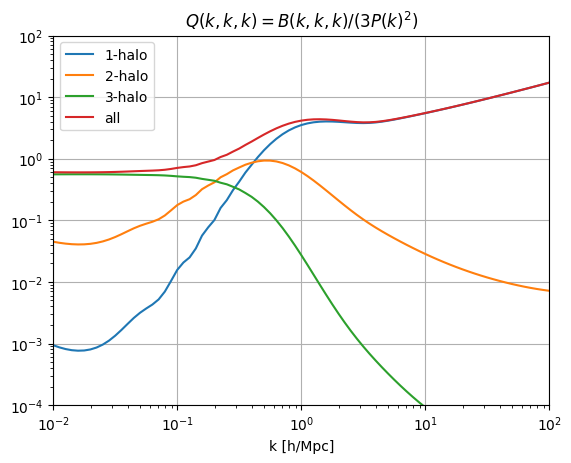

In [13]:
plt.title(r"$Q(k,k,k)=B(k,k,k)/(3 P(k)^2)$")
plt.xlabel("k [h/Mpc]")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlim(0.01, 100)
plt.ylim(1e-4, 100)
plt.plot(ks, result[2]['m-m-m']/3/Pk_hm['m-m']/Pk_hm['m-m'], label='1-halo')
plt.plot(ks, result[1]['m-m-m']/3/Pk_hm['m-m']/Pk_hm['m-m'], label='2-halo')
plt.plot(ks, result[0]['m-m-m']/3/Pk_hm['m-m']/Pk_hm['m-m'], label='3-halo')
plt.plot(ks, result[3]['m-m-m']/3/Pk_hm['m-m']/Pk_hm['m-m'], label='all')


plt.legend()

